# Exercise 4

## Preliminaries

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx, 1)

    return onehot

#example:
idx2onehot(3*torch.ones(7, dtype=torch.long),n=10)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Basics/Repetition  of VAE

In the lecture we have shown that
$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$

where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of the decoder network $D$ and the encoder network $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient so that the average over index $l$ becomes trivial.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term for the two multivariate normal distributions can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$. The decoder produces the reconstruction `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

In [304]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        means, log_var = self.encoder.forward(x,c)
        recon_x = self.decoder.forward(means, c) #IS MEANS AS INPUT CORRECT?
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return recon_x, means, log_var
        
    def sampling(self, n=2, c=None):
        """
        Generates new samples by feeding a random latent vector to the decoder.
        Arguments:
            n (int): amount of samples 
            c      : None or tensor of dimension (batch_size, 1) (labels to condition on)
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        z = torch.randn(size=(n,latent_dim))

        x_sampled = self.decoder.forward(z, c)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional the input layersize needs to be increased for the additional one-hot vector input
        self.layer_sizes = layer_sizes
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        #extend input layer if conditional=True
        if conditional:
            self.layer_sizes[0] += self.num_labels
        
        #Define layers
        self.layers = []
        for i in range(len(self.layer_sizes)-1):
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
            nn.init.xavier_normal_(self.layers[-1].weight)
        self.layers.append(nn.Linear(self.layer_sizes[-1], 2*latent_dim))
        nn.init.xavier_normal_(self.layers[-1].weight)
        self.layers = nn.ModuleList(self.layers)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        if c is not None:
            c = idx2onehot(c, n=self.num_labels)
            x = torch.cat((x,c),1)
        
        for i in range(len(self.layer_sizes)-1):
            x = self.layers[i](x)
            activation = nn.Sigmoid()
            x = activation(x)

        #output layer (is linear fine?)
        x = self.layers[-1](x)
        
        means = x[:,:self.latent_dim]
        log_vars = x[:,self.latent_dim:]
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################        
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional is True, the input layersize needs to be increased for the additional one-hot vector input
        self.layer_sizes = layer_sizes
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        #extend input layer if conditional=True
        input_size = self.latent_dim
        if conditional:
            input_size += self.num_labels
        
        #Define layers
        self.layers = []
        self.layers.append(nn.Linear(input_size, self.layer_sizes[0]))
        nn.init.xavier_normal_(self.layers[-1].weight)
        for i in range(len(self.layer_sizes)-1):
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
            nn.init.xavier_normal_(self.layers[-1].weight)
        self.layers = nn.ModuleList(self.layers)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
            
    def forward(self, z, c=None):
        """
        Argumetns:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        if c is not None:
            c = idx2onehot(c, self.num_labels)
            z = torch.cat((z,c),1)
        
        for i in range(len(self.layer_sizes)-1):
            z = self.layers[i](z)
            activation = nn.Sigmoid()
            z = activation(z)

        #output layer (is linear fine?)
        x = self.layers[-1](z)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

Hint: Use the following choice of hyperparameter $\sigma_G = 1$.

In [147]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################
    x = x.view(-1,784)
    recon_x = recon_x.view(-1,784)
    neg_ELBO = torch.sum(mu**2 + torch.exp(log_var)**2 - 2*log_var - 1) / 2 + torch.sum((x - recon_x)**2) 
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################
    return neg_ELBO

The formula for the neg_ELBO is taken from the basics/VAE part that you can see above. You can find the derivation there.

### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The amount of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved by searching for different hyperparameters.
* Simply run the code to thrain the VAE

In [305]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)  

Train Epoch: 0 [0/60000 (0%)]	Loss: 16432.730469
Train Epoch: 0 [12800/60000 (21%)]	Loss: 3310.506592
Train Epoch: 0 [25600/60000 (43%)]	Loss: 3367.077393
Train Epoch: 0 [38400/60000 (64%)]	Loss: 3023.554199
Train Epoch: 0 [51200/60000 (85%)]	Loss: 3435.484863
====> Epoch: 0 Average loss: 52.1635
Train Epoch: 1 [0/60000 (0%)]	Loss: 2984.389648
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2986.273438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 3083.782959
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2684.731201
Train Epoch: 1 [51200/60000 (85%)]	Loss: 3095.241211
====> Epoch: 1 Average loss: 46.5600
Train Epoch: 2 [0/60000 (0%)]	Loss: 2714.391602
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2757.925537
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2957.326172
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2547.531738
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2933.980957
====> Epoch: 2 Average loss: 44.0889
Train Epoch: 3 [0/60000 (0%)]	Loss: 2619.252197
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2701.813721
Train E

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 
 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

Original             Reconstructed


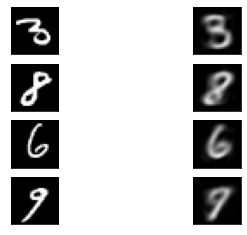

In [306]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

Our reconstruction is far away from being really good, but one can clearly see that there are strong similarities with the original images. In the last three cases one can also easily recognize which number the reconstruction shows. The reconstructed numbers are equal to the numbers being reconstructed. In case of the first image the reconstruction is worse, one cannot clearly see if the reconstructed number is a 3 (correct) or an 8 (incorrect). However, there is still some correspondence between the original and the reconstruction. As we learned in the lecture, all the reconstruction are blurry.

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

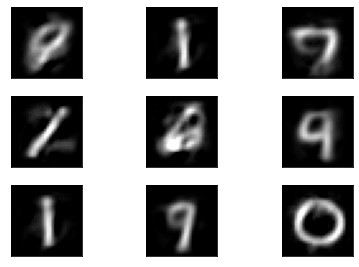

In [307]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

One can see a set of images that has a lot of similarities with the numbers from the MNIST dataset. In most cases one can identify a unique number on each image. However, all the numbers are blurry and in some cases it is not clear which number is shown.

### Training a second VAE with larger latent space dimension
Note that the quality of the reconstruction will also depend on the dimension of the latent space. To explore this, train a second model called `vae2` and use it to reconstruct a few example digits to evaluate the change in quality. Comment on your findings.

We keep everything unchanged except for the latent space dimension (16 instead of 2) and the number of epochs (25 instead of 15).

In [308]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 16 
vae2 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae2 = vae2.to(device)

optimizer = optim.Adam(vae2.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae2.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae2(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 25 
for epoch in range(epochs):
    train(epoch)  

Train Epoch: 0 [0/60000 (0%)]	Loss: 18312.640625
Train Epoch: 0 [12800/60000 (21%)]	Loss: 3338.980469
Train Epoch: 0 [25600/60000 (43%)]	Loss: 3322.162598
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2944.141846
Train Epoch: 0 [51200/60000 (85%)]	Loss: 3394.949219
====> Epoch: 0 Average loss: 51.8264
Train Epoch: 1 [0/60000 (0%)]	Loss: 2887.720947
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2834.346191
Train Epoch: 1 [25600/60000 (43%)]	Loss: 3018.302246
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2599.050293
Train Epoch: 1 [51200/60000 (85%)]	Loss: 3019.801514
====> Epoch: 1 Average loss: 45.0611
Train Epoch: 2 [0/60000 (0%)]	Loss: 2609.113525
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2531.707764
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2512.500732
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2181.397949
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2362.026855
====> Epoch: 2 Average loss: 38.6305
Train Epoch: 3 [0/60000 (0%)]	Loss: 2162.787354
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2088.676025
Train E

Original             Reconstructed


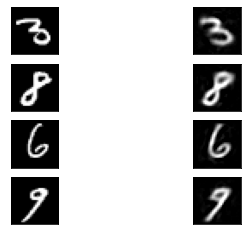

In [309]:
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae2(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

With increase latent space dimension ($dim(z) = 16$) the training loss is improved only slightly. Visibly, the reconstruction has slightly improved. The reconstructions are more accurate and less blurry.

### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [310]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 15373.100586
Train Epoch: 1 [12800/60000 (21%)]	Loss: 3260.328369
Train Epoch: 1 [25600/60000 (43%)]	Loss: 3306.702881
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2903.232910
Train Epoch: 1 [51200/60000 (85%)]	Loss: 3250.111572
====> Epoch: 1 Average loss: 50.4243
Train Epoch: 2 [0/60000 (0%)]	Loss: 2618.602295
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2553.123291
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2531.468994
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2298.805664
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2718.985840
====> Epoch: 2 Average loss: 39.6579
Train Epoch: 3 [0/60000 (0%)]	Loss: 2265.010498
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2308.913574
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2311.607910
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2188.752441
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2407.714600
====> Epoch: 3 Average loss: 36.3345
Train Epoch: 4 [0/60000 (0%)]	Loss: 2125.833740
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2151.051025
Train E

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

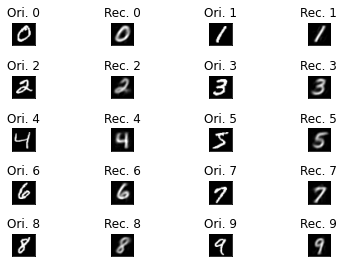

In [311]:
x,l = next(iter(train_loader))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.long)
    plt.subplot(5,4,2*i+1)
    plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))

Compared to the VAE with latent space dimension 2 the reconstructions have improved noticably. We cannot find any ambiguities in the reconstructions.

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

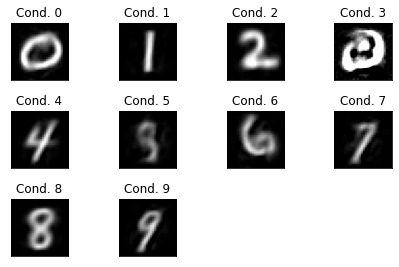

In [312]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(1).type(torch.long)
    sample = cvae.sampling(n=1, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))

Many numbers can be reconstructed well. But the reconstruction for 3 is very poor. Maybe the CVAE model does not converge as fast as the VAE model, one would have to train for more epochs to get a better result. 

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the model vae trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

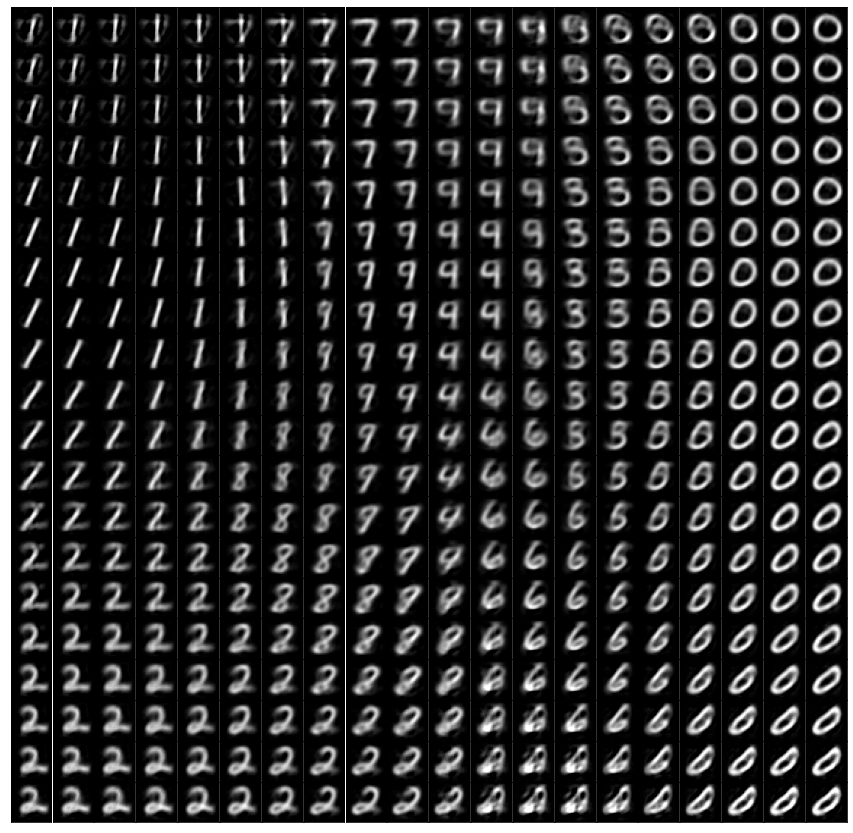

In [313]:
#first plot: decoder output as a function of the position in the latent space
x = torch.tensor(np.linspace(-1,1,20), dtype=torch.float64)
grid_x, grid_y = torch.meshgrid((x,x))
grid_x = torch.unsqueeze(grid_x, 2)
grid_y = torch.unsqueeze(grid_y, 2)
grid = torch.cat((grid_x, grid_y),2)
grid = grid.view(400,-1).float()
sample = vae.decoder.forward(grid, c=None)

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0, 400):
    plt.subplot(20,20,i+1)
    imshow(sample[i].detach().cpu().view(28,28))
    plt.xticks([])
    plt.yticks([])

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

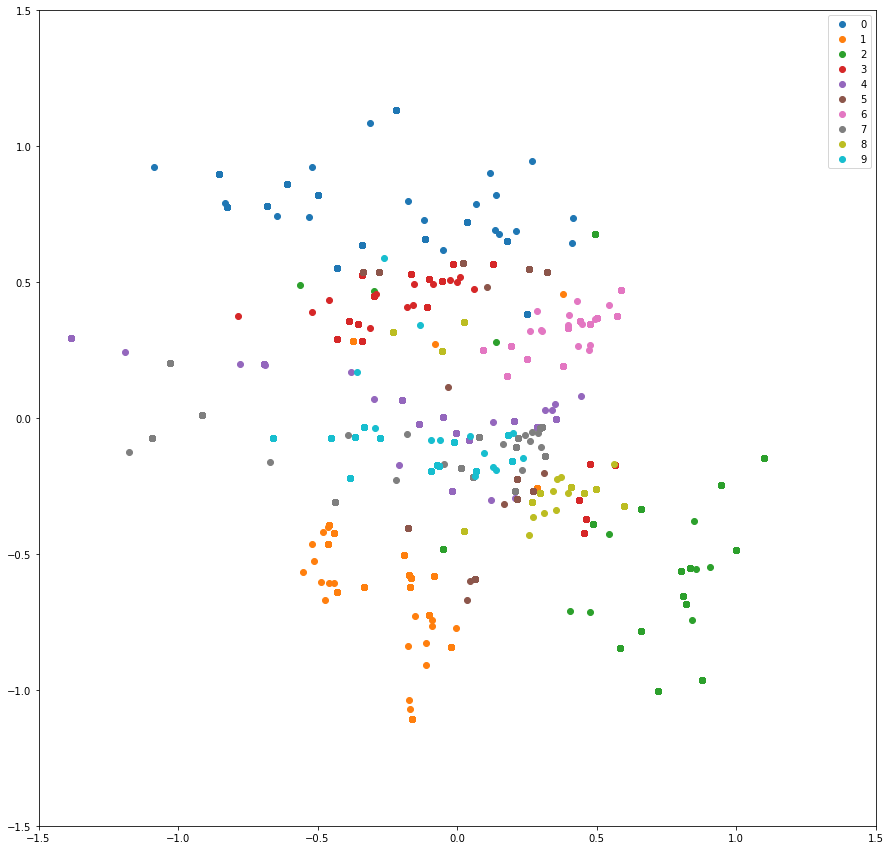

In [343]:
plt.figure(figsize=(15,15))
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))


#second plot: distribution of training data in the latent space for VAE model
batch_idx, data = list(enumerate(train_loader))[0]
x, y = data

for i in range(10):
    batch_idx, data = list(enumerate(train_loader))[1]
    x_, y_ = data

    x = torch.cat((x,x_),0)
    y = torch.cat((y,y_),0)

for i in range(10):
    x_i = x[y==i]
    z_i, _ = vae.encoder.forward(x_i, c=None)
    z_i = z_i.detach().numpy().T
    plt.plot(z_i[0], z_i[1], marker="o", linestyle="None", label=i)
plt.legend()

Ideally we would see well separated regions, each corresponding to one unique number. Instead, we see that the latent space representations lie in overlapping regions. Some numbers overlap more than others (good separation: (2,green), bad separation: (purple, 4))

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that migh cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

We see that the regions corresponding to different numbers overlap strongly close to the origin of ordinates. Consequently, the VAE will have a hard time reconstructing latent space vectors from this region. We test it by taking points from a square of side length 0.6 centered around (0.1, -0.1).

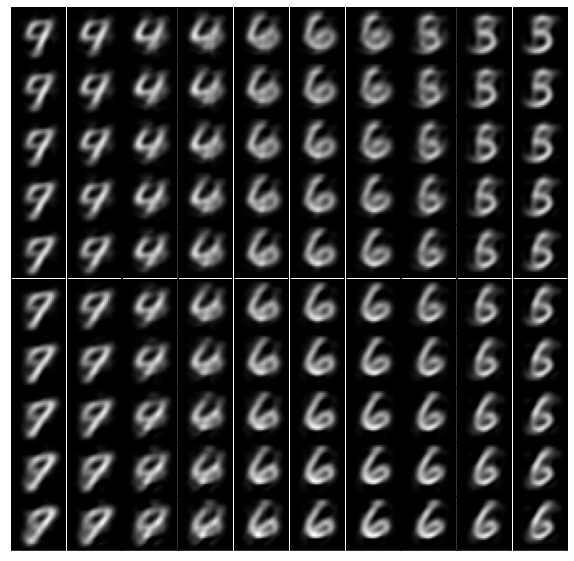

In [349]:
x = torch.tensor(np.linspace(0.05,0.45,10), dtype=torch.float64)
y = torch.tensor(np.linspace(-0.05,0.45,10), dtype=torch.float64)
grid_x, grid_y = torch.meshgrid((x,y))
grid_x = torch.unsqueeze(grid_x, 2)
grid_y = torch.unsqueeze(grid_y, 2)
grid = torch.cat((grid_x, grid_y),2)
grid = grid.view(100,-1).float()
sample = vae.decoder.forward(grid, c=None)

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0, 100):
    plt.subplot(10,10,i+1)
    imshow(sample[i].detach().cpu().view(28,28))
    plt.xticks([])
    plt.yticks([])

We notice that many numbers are reconstructed very badly. They look for example like a mixture of 4, 9, 6 and 0 (4th column).

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the model cvae trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

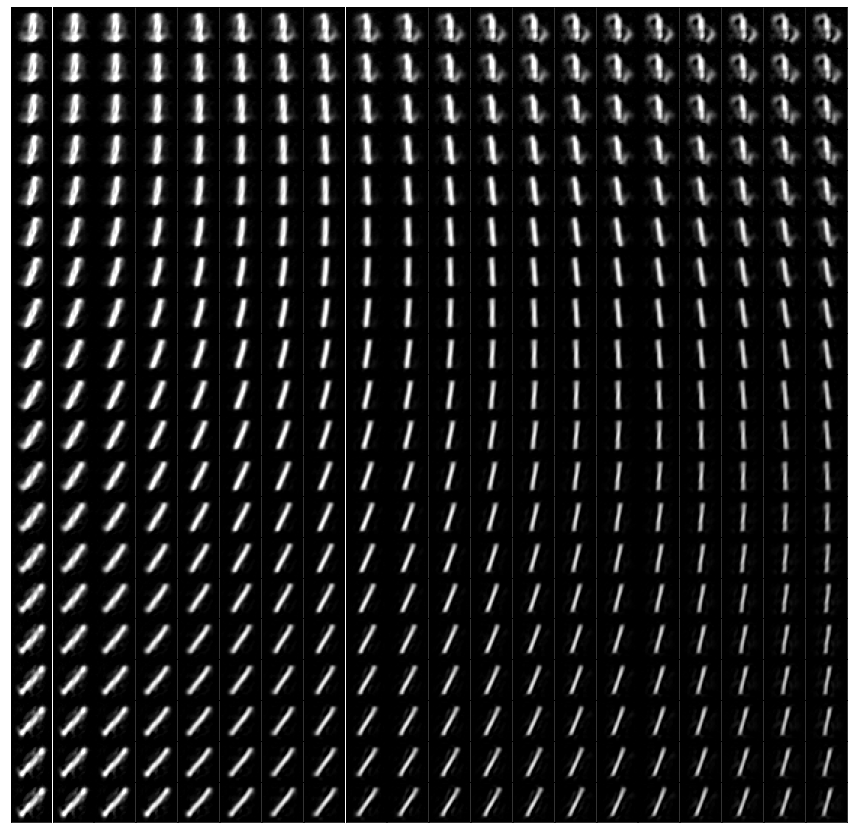

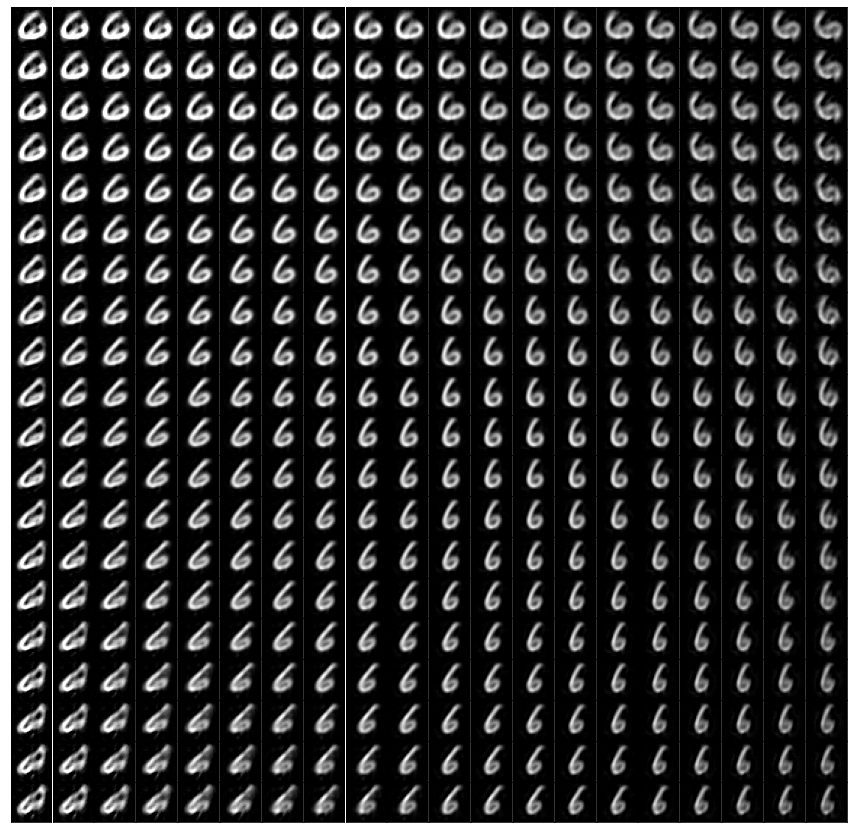

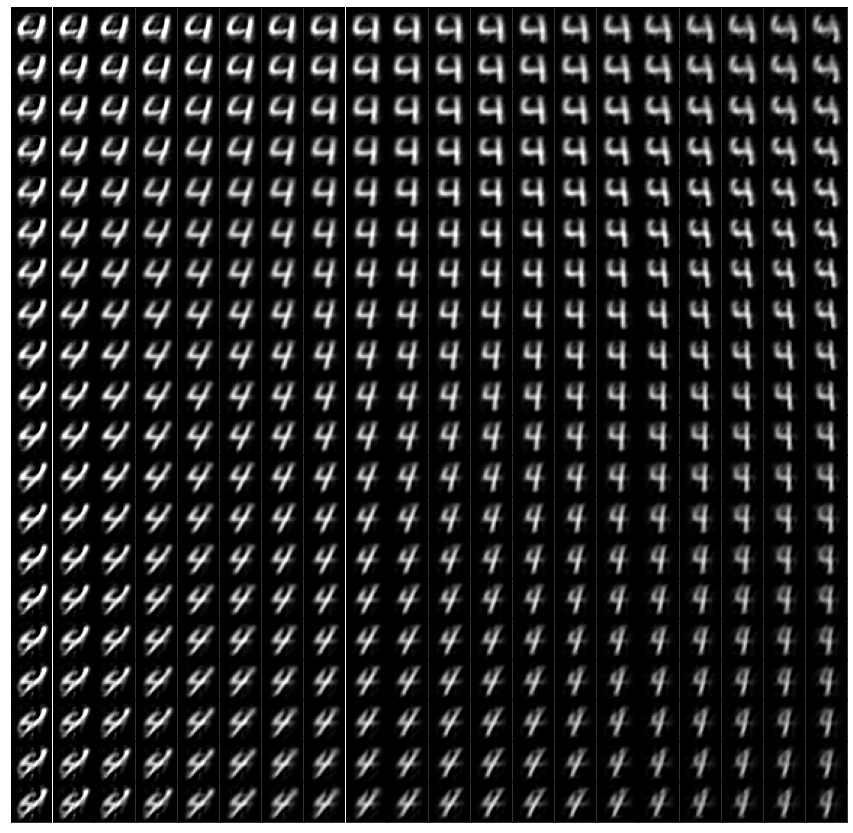

In [351]:
#Plot for 1
x = torch.tensor(np.linspace(-1,1,20), dtype=torch.float64)
grid_x, grid_y = torch.meshgrid((x,x))
grid_x = torch.unsqueeze(grid_x, 2)
grid_y = torch.unsqueeze(grid_y, 2)
grid = torch.cat((grid_x, grid_y),2)
grid = grid.view(400,-1).float()

labels = torch.ones(400, dtype=torch.long)

sample = cvae.decoder.forward(grid, c=labels)

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0, 400):
    plt.subplot(20,20,i+1)
    imshow(sample[i].detach().cpu().view(28,28))
    plt.xticks([])
    plt.yticks([])

    
#Plot for 6
labels = 6*torch.ones(400, dtype=torch.long)

sample = cvae.decoder.forward(grid, c=labels)

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0, 400):
    plt.subplot(20,20,i+1)
    imshow(sample[i].detach().cpu().view(28,28))
    plt.xticks([])
    plt.yticks([])

    
#Plot for 4
labels = 4*torch.ones(400, dtype=torch.long)

sample = cvae.decoder.forward(grid, c=labels)

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0, 400):
    plt.subplot(20,20,i+1)
    imshow(sample[i].detach().cpu().view(28,28))
    plt.xticks([])
    plt.yticks([])

### Visualisation of Latent Space via Decoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


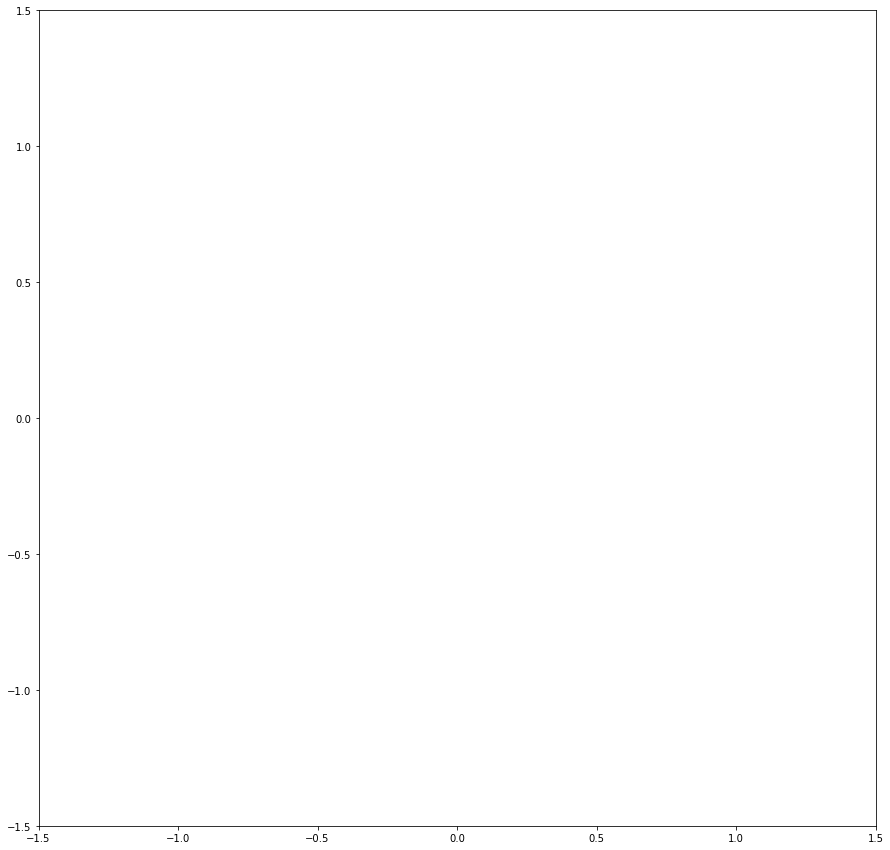

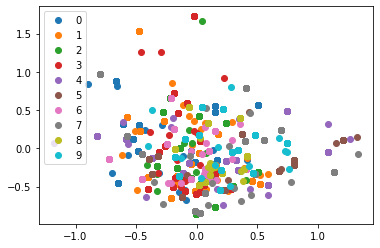

In [354]:
plt.figure(figsize=(15,15))
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))


#distribution of training data in the latent space for CVAE model
batch_idx, data = list(enumerate(train_loader))[0]
x, y = data

for i in range(10):
    batch_idx, data = list(enumerate(train_loader))[1]
    x_, y_ = data

    x = torch.cat((x,x_),0)
    y = torch.cat((y,y_),0)

plt.figure()
for i in range(10):
    x_i = x[y==i]
    labels = i*torch.ones(x_i.shape[0], dtype=torch.long)
    z_i, _ = cvae.encoder.forward(x_i, c=labels)
    z_i = z_i.detach().numpy().T
    plt.plot(z_i[0], z_i[1], marker="o", linestyle="None", label=i)
plt.legend()

In comparison to the scatter plot in task 2 the instances are worse separated in the "classical" latent space. Note that this is not necessarily mean that the reconstructions become worse: This scatter plot does not show the whole input space for the decoder, because the label information is missing. So the inputs of the decoder for two different numbers are well separated in the input space even if the latent space representations are very similar. 
Bad samples occur when the regions for two different numbers are not well separated. When the latent space vector comes from a place in latent space where several regions overlap it can happen that the reconstruction is a "mixture of two numbers". This is not a problem in case of the CVAE, because by construction all numbers are well separated in the input space (and have a very similar distribution in latent space.)

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule. The label $\hat y$ for a given ..$x$ is predicted according to:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y) \ ,$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ in the following way: Given an input image, run the CVAE 10 times, each time conditioning one one of the different class labels $y$. Calculate the losses for each case and use them to design a classifier. Note that the network was never trained as classifier, but is still able to perform the task.  

In [369]:
def predict(CVAE, x):
    M = x.shape[0]
    results = torch.empty(size=(M,10))
    for i in range(10):
        labels = i*torch.ones(M, dtype=torch.long)
        means,_ = CVAE.encoder.forward(x, c=labels)
        means = torch.sum(means**2, dim=1)
        results[:,i] = means
    predicted_labels = torch.argmin(results,dim=1)
    
    return predicted_labels

Finally, we test the predictor by applying it to the first minibatch.

In [375]:
batch_idx, data = list(enumerate(train_loader))[0]
x, y = data

predicted_labels = predict(cvae, x)

print("Success rate:")
print((torch.sum(predicted_labels==y)/predicted_labels.shape[0]).detach().numpy())

Success rate:
0.28125


The rate of correctly classified instances is clearly better than guessing (0.1 in case of 10 classes). However, the error rate is very high compared with discriminative models (for example using CNN).